# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
#azdias['ALTERSKATEGORIE_GROB'].max()

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#print(azdias.head(50))
feat_info



attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
..                    ...               ...          ...                ...
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
60            KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61            KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62            KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63            KBA05_ANTG4     microcell_rr3      ordinal               [-1]
64           KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]
65              KBA05_GBZ     microcell_rr3      ordinal             [-1,0]
66               BALLRAUM          postcode      ordinal               [-1]
67               EWDICHTE          postcode      ordinal               [-1]
68             INNENSTADT          postcode      ordinal               [-1]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal             [-1,0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal             [-1,0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

# visual analysis -> some naturally missing values
#azdias.isnull()
# as there are some missung values -> how much?
azdias.isnull().sum()


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [6]:
#feat_info['missing_or_unknown'][0]
# data is stored as string -> convert
missing_or_unknown = feat_info['missing_or_unknown'].replace(['\[','\]'], '', regex=True)

#missing_or_unknown
missing_or_unknown = [i.split(',') for i in missing_or_unknown]
#missing_or_unknown

for i in range(len(missing_or_unknown)):
    for j in range(len(missing_or_unknown[i])):
        if missing_or_unknown[i][j] in ['','X','XX']:
            pass
        else:
            missing_or_unknown[i][j] = float(missing_or_unknown[i][j])
missing_or_unknown
    
    


[[-1.0, 0.0],
 [-1.0, 0.0, 9.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 9.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [''],
 [-1.0, 0.0],
 [''],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0, 'X'],
 ['XX'],
 [-1.0, 'XX'],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [''],
 [-1.0, 0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [''],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0, 9.0],
 [-1.0, 0.0],
 [-1.0, 9.0]]

In [7]:
# replace with NaN
for i in range(len(missing_or_unknown)):
    col = feat_info.iloc[i]['attribute']
    for j in range(len(missing_or_unknown[i])):
        azdias[col].replace(missing_or_unknown[i][j], np.NaN, regex=True, inplace=True)

In [8]:
# save df for later use
mou_df = feat_info
mou_df['missing_or_unknown'] = missing_or_unknown
mou_df

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical        [-1.0, 0.0]
1    ALTERSKATEGORIE_GROB            person      ordinal   [-1.0, 0.0, 9.0]
2               ANREDE_KZ            person  categorical        [-1.0, 0.0]
3           CJT_GESAMTTYP            person  categorical              [0.0]
4       FINANZ_MINIMALIST            person      ordinal             [-1.0]
5           FINANZ_SPARER            person      ordinal             [-1.0]
6        FINANZ_VORSORGER            person      ordinal             [-1.0]
7          FINANZ_ANLEGER            person      ordinal             [-1.0]
8   FINANZ_UNAUFFAELLIGER            person      ordinal             [-1.0]
9        FINANZ_HAUSBAUER            person      ordinal             [-1.0]
10              FINANZTYP            person  categorical             [-1.0]
11            GEBURTSJAHR            person      numeric              [0.0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal        [-1.0, 0.0]
15    LP_LEBENSPHASE_FEIN            person        mixed              [0.0]
16    LP_LEBENSPHASE_GROB            person        mixed              [0.0]
17        LP_FAMILIE_FEIN            person  categorical              [0.0]
18        LP_FAMILIE_GROB            person  categorical              [0.0]
19         LP_STATUS_FEIN            person  categorical              [0.0]
20         LP_STATUS_GROB            person  categorical              [0.0]
21       NATIONALITAET_KZ            person  categorical        [-1.0, 0.0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed        [-1.0, 0.0]
23         RETOURTYP_BK_S            person      ordinal              [0.0]
24              SEMIO_SOZ            person      ordinal        [-1.0, 9.0]
25              SEMIO_FAM            person      ordinal        [-1.0, 9.0]
26              SEMIO_REL            person      ordinal        [-1.0, 9.0]
27              SEMIO_MAT            person      ordinal        [-1.0, 9.0]
28             SEMIO_VERT            person      ordinal        [-1.0, 9.0]
29             SEMIO_LUST            person      ordinal        [-1.0, 9.0]
..                    ...               ...          ...                ...
55            OST_WEST_KZ          building  categorical             [-1.0]
56               WOHNLAGE          building        mixed             [-1.0]
57        CAMEO_DEUG_2015     microcell_rr4  categorical          [-1.0, X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed         [-1.0, XX]
60            KBA05_ANTG1     microcell_rr3      ordinal             [-1.0]
61            KBA05_ANTG2     microcell_rr3      ordinal             [-1.0]
62            KBA05_ANTG3     microcell_rr3      ordinal             [-1.0]
63            KBA05_ANTG4     microcell_rr3      ordinal             [-1.0]
64           KBA05_BAUMAX     microcell_rr3        mixed        [-1.0, 0.0]
65              KBA05_GBZ     microcell_rr3      ordinal        [-1.0, 0.0]
66               BALLRAUM          postcode      ordinal             [-1.0]
67               EWDICHTE          postcode      ordinal             [-1.0]
68             INNENSTADT          postcode      ordinal             [-1.0]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal        [-1.0, 0.0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal        [-1.0, 0.0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

In [9]:
feat_info['attribute']

0                  AGER_TYP
1      ALTERSKATEGORIE_GROB
2                 ANREDE_KZ
3             CJT_GESAMTTYP
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
10                FINANZTYP
11              GEBURTSJAHR
12          GFK_URLAUBERTYP
13         GREEN_AVANTGARDE
14               HEALTH_TYP
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
17          LP_FAMILIE_FEIN
18          LP_FAMILIE_GROB
19           LP_STATUS_FEIN
20           LP_STATUS_GROB
21         NATIONALITAET_KZ
22    PRAEGENDE_JUGENDJAHRE
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
              ...          
55              OST_WEST_KZ
56                 WOHNLAGE
57          CAMEO_DEUG_2015
58           CAMEO_DEU_2015
59          CAMEO_IN

In [10]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing = azdias.isnull().sum()

n_data = azdias.shape[0]

missing_p = missing/(n_data/100)

In [10]:
#missing_p

missing_df = pd.DataFrame(missing_p, columns = ['missing_p'])

In [13]:
missing_df.head()

missing_p
AGER_TYP              76.955435
ALTERSKATEGORIE_GROB   0.323264
ANREDE_KZ              0.000000
CJT_GESAMTTYP          0.544646
FINANZ_MINIMALIST      0.000000

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

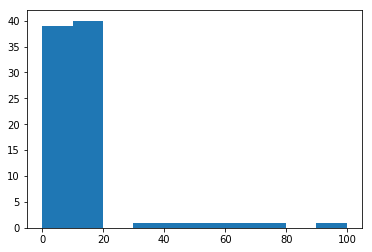

In [11]:
# Investigate patterns in the amount of missing data in each column.
#plt.hist(missing)
plt.hist(missing_p)

# the most columns seem to have less than 20% missing data -> outliers are >20%

In [12]:
outliers = missing_df[missing_df['missing_p']> 20]

outliers = outliers.transpose()
outliers

AGER_TYP  GEBURTSJAHR   TITEL_KZ   ALTER_HH  KK_KUNDENTYP  \
missing_p  76.955435    44.020282  99.757636  34.813699     65.596749   

           KBA05_BAUMAX  
missing_p     53.468668

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_old = azdias
azdias = azdias.drop(outliers, axis = 1)

print(azdias_old.shape)
print(azdias.shape)

(891221, 85)
(891221, 79)


In [17]:
#azdias = azdias_old

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Amount of missing data in each column
- Are there any patterns in missing values?
- Which columns were removed from the dataset?

After a first visual analysis of the data set, some naturally missing values were identified. Afer applying the information for missing or unknown data even more missing datapoint were identified.

Next question was the exact amount of missing values per column and the percentage of missing values.
The histogram shows, that most columns have less than 20% missing values, so the conclusion is, that columns with more than 20% of missing values should be considered as outliers.
The six columns with more than 20% of missing values are AGER_TYP (76.955435), GEBURTSJAHR (44.020282), TITEL_KZ (99.757636), ALTER_HH (34.813699), KK_KUNDENTYP (65.596749), KBA05_BAUMAX (53.468668)				

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
missing_in_row = azdias.isnull().sum(axis=1)
missing_in_row
missing_in_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

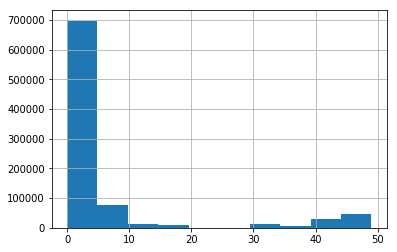

In [19]:
missing_in_row.hist()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#add n of values per row
missing_in_row = pd.DataFrame(missing_in_row, columns = ['missing'])
azdias = azdias.join(missing_in_row)



In [21]:
azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   

   FINANZ_HAUSBAUER  FINANZTYP   ...     PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  \
0                 3          4   ...            NaN         NaN         NaN   
1                 5          1   ...            3.0         2.0         1.0   
2                 5          1   ...            3.0         1.0         0.0   
3                 2          6   ...            2.0         2.0         0.0   
4                 2          5   ...            4.0         2.0         1.0   

   PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  missing  
0          NaN       NaN       NaN     NaN          NaN       NaN       43  
1          1.0       5.0       4.0     3.0          5.0       4.0        0  
2          1.0       4.0       4.0     3.0          5.0       2.0        0  
3          1.0       3.0       4.0     2.0          3.0       3.0        7  
4          2.0       3.0       3.0     4.0          6.0       5.0        0  

[5 rows x 80 columns]

In [22]:
def divide_by_missing(df, missing, column='missing'):
    df1 = df[df[column] <= missing]
    df2 = df[df[column] > missing]
    return df1, df2

In [23]:
azdias_1, azdias_2 = divide_by_missing(azdias, 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba89762780>]], dtype=object)

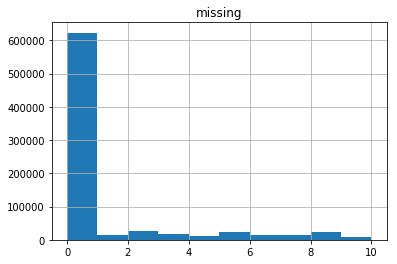

In [24]:
azdias_1.hist(column='missing')

In [25]:
# drop missing
azdias_1.drop('missing', axis=1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#You can use seaborn's countplot() function to create a bar chart of code frequencies and matplotlib's subplot() function to put bar charts for the two subplots side by side.
def compare(column, df_1=azdias_1, df_2 =azdias_2):
    fig, ax = plt.subplots(1,2)
    sns.countplot(df_1[column], ax= ax[0])
    sns.countplot(df_2[column], ax= ax[1])
    plt.subplots_adjust(wspace = 0.5)
    fig.show()
    return


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


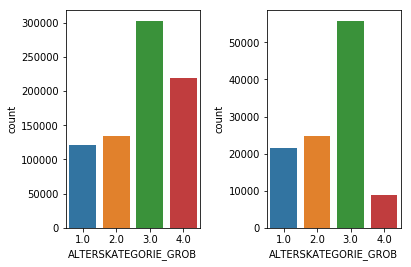

In [27]:
compare('ALTERSKATEGORIE_GROB')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


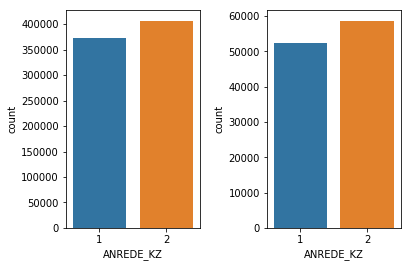

In [28]:
compare('ANREDE_KZ')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


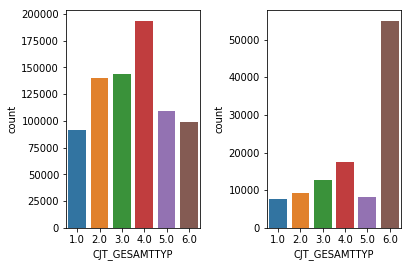

In [29]:
compare('CJT_GESAMTTYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


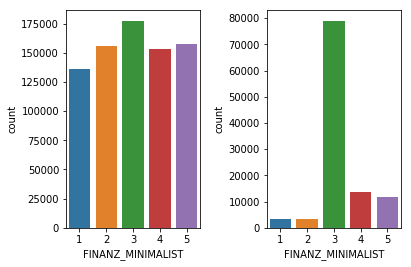

In [30]:
compare('FINANZ_MINIMALIST')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


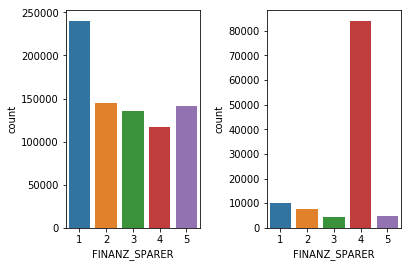

In [31]:
compare('FINANZ_SPARER')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


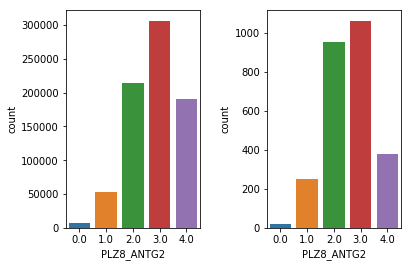

In [32]:
compare('PLZ8_ANTG2')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


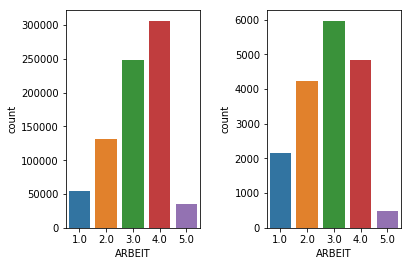

In [33]:
compare('ARBEIT')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
feat_info_old = feat_info
outlier_columns = outliers.columns
for col in outlier_columns:
    feat_info = feat_info[feat_info.attribute != col]


In [29]:
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_vars = feat_info[feat_info['type']=='categorical']
cat_vars

attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical        [-1.0, 0.0]
3      CJT_GESAMTTYP            person  categorical              [0.0]
10         FINANZTYP            person  categorical             [-1.0]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical              [0.0]
18   LP_FAMILIE_GROB            person  categorical              [0.0]
19    LP_STATUS_FEIN            person  categorical              [0.0]
20    LP_STATUS_GROB            person  categorical              [0.0]
21  NATIONALITAET_KZ            person  categorical        [-1.0, 0.0]
38       SHOPPER_TYP            person  categorical             [-1.0]
39           SOHO_KZ            person  categorical             [-1.0]
41          VERS_TYP            person  categorical             [-1.0]
42          ZABEOTYP            person  categorical        [-1.0, 9.0]
52       GEBAEUDETYP          building  categorical        [-1.0, 0.0]
55       OST_WEST_KZ          building  categorical             [-1.0]
57   CAMEO_DEUG_2015     microcell_rr4  categorical          [-1.0, X]
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

In [31]:
for index, row in cat_vars.iterrows():
    attribute = row['attribute']
    print(attribute)
    print(azdias_1[attribute].unique())

ANREDE_KZ
[2 1]
CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP
[1 6 5 2 4 3]
GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
GREEN_AVANTGARDE
[0 1]
LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ
[  1.   3.   2.  nan]
SHOPPER_TYP
[  3.   2.   1.   0.  nan]
SOHO_KZ
[ 1.  0.]
VERS_TYP
[  2.   1.  nan]
ZABEOTYP
[5 3 4 1 6 2]
GEBAEUDETYP
[ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ
['W' 'O']
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


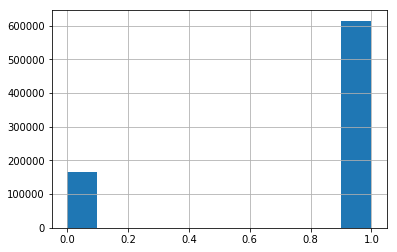

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.

#OST_WEST_KZ
azdias_1.OST_WEST_KZ=azdias_1['OST_WEST_KZ'].replace({'O': 0, 'W':1})
azdias_1.OST_WEST_KZ.hist()

In [33]:
# identified columns
to_encode=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

In [34]:
azdias_1_encoded = pd.get_dummies(azdias_1, columns= to_encode)

In [35]:
azdias_1_encoded.head(n=20)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                    1.0          2                  1              5   
2                    3.0          2                  1              4   
3                    4.0          2                  4              2   
4                    3.0          1                  4              3   
5                    1.0          2                  3              1   
6                    2.0          2                  1              5   
7                    1.0          1                  3              3   
8                    3.0          1                  4              4   
9                    3.0          2                  2              4   
10                   3.0          2                  2              2   
12                   3.0          1                  5              3   
13                   1.0          2                  1              4   
15                   4.0          2                  4              1   
16                   1.0          2                  4              3   
18                   2.0          2                  2              4   
19                   3.0          1                  5              2   
20                   2.0          2                  4              3   
21                   2.0          1                  3              4   
22                   1.0          1                  1              5   
23                   3.0          1                  5              3   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                  2               5                      4                 5   
2                  1               2                      3                 5   
3                  5               2                      1                 2   
4                  4               1                      3                 2   
5                  5               2                      2                 5   
6                  1               5                      4                 3   
7                  4               1                      3                 2   
8                  2               4                      2                 2   
9                  2               3                      5                 4   
10                 5               3                      1                 5   
12                 4               2                      4                 1   
13                 3               5                      5                 2   
15                 5               1                      1                 4   
16                 1               4                      5                 1   
18                 1               5                      4                 1   
19                 3               1                      3                 1   
20                 1               4                      5                 1   
21                 1               2                      5                 1   
22                 3               5                      5                 5   
23                 3               2                      2                 1   

    GREEN_AVANTGARDE  HEALTH_TYP        ...          CAMEO_DEU_2015_7E  \
1                  0         3.0        ...                          0   
2                  1         3.0        ...                          0   
3                  0         2.0        ...                          0   
4                  0         3.0        ...                          0   
5                  0         3.0        ...                          0   
6                  0         2.0        ...                          0   
7                  0         1.0        ...                          0   
8                  1         3.0        ...                          0   
9                  1         2.0        ...                          0   
10                 0        

#### Discussion 1.2.1: Re-Encode Categorical Features

- Findings and decisions regarding categorical features
- Which ones did you keep, which did you drop, and what engineering steps did you perform?

I identified the columns 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015' to bee one hot encoded.

The binary Variable OST_WEST_K was transformed by repolacing the letters representing former eastern and western germany by numerical values 0 and 1.

The Variables identified earlier as outliers were removed from the dataset

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#mixed features
mixed_vars = feat_info[feat_info['type']=='mixed']
mixed_vars

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed              [0.0]
16    LP_LEBENSPHASE_GROB            person  mixed              [0.0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed        [-1.0, 0.0]
56               WOHNLAGE          building  mixed             [-1.0]
59        CAMEO_INTL_2015     microcell_rr4  mixed         [-1.0, XX]
79            PLZ8_BAUMAX    macrocell_plz8  mixed        [-1.0, 0.0]

In [37]:
#azdias_1_encoded['PRAEGENDE_JUGENDJAHRE']

#dictionarys based on Data_Dictionary.md
dict_decade =  {1: 40.0,
                2: 40.0,                
                3: 50.0,
                4: 50.0,
                5: 60.0,
                6: 60.0,
                7: 60.0,
                8: 70.0,
                9: 70.0,
                10: 80.0,
                11: 80.0,
                12: 80.0,
                13: 80.0,
                14: 90.0, 
                15: 90.0,
               }

dict_movement = {1: 0.0,
                 2: 1.0,
                 3: 0.0,
                 4: 1.0,
                 5: 0.0,
                 6: 1.0,
                 7: 1.0,
                 8: 0.0,
                 9: 1.0,
                 10: 0.0,
                 11: 1.0,
                 12: 0.0,
                 13: 1.0,
                 14: 0.0,
                 15: 1.0,
                }

In [38]:
azdias_1_encoded['PRAEGENDE_JUGENDJAHRE_DEKADE'] = azdias_1_encoded['PRAEGENDE_JUGENDJAHRE']
azdias_1_encoded['PRAEGENDE_JUGENDJAHRE_BEWEGUNG'] = azdias_1_encoded['PRAEGENDE_JUGENDJAHRE']

azdias_1_encoded.PRAEGENDE_JUGENDJAHRE_DEKADE = azdias_1_encoded.PRAEGENDE_JUGENDJAHRE_DEKADE.replace(dict_decade)
azdias_1_encoded.PRAEGENDE_JUGENDJAHRE_BEWEGUNG = azdias_1_encoded.PRAEGENDE_JUGENDJAHRE_BEWEGUNG.replace(dict_movement)

In [45]:
#azdias_1_encoded.PRAEGENDE_JUGENDJAHRE_DEKADE

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#save = azdias_1_encoded
#azdias_1_encoded['CAMEO_INTL_2015_WEALTH'], azdias_1_encoded['CAMEO_INTL_2015_LST'] = azdias_1_encoded.CAMEO_INTL_2015.apply(lambda x: divmod(int(x),10))
dict_WEALTH = {'11': 1.0,
               '12': 1.0,
               '13': 1.0,
               '14': 1.0,
               '15': 1.0,
               '21': 2.0,
               '22': 2.0,
               '23': 2.0,
               '24': 2.0,
               '25': 2.0,
               '31': 3.0,
               '32': 3.0,
               '33': 3.0,
               '34': 3.0, 
               '35': 3.0,
               '41': 4.0,
               '42': 4.0,
               '43': 4.0,
               '44': 4.0, 
               '45': 4.0,
               '51': 5.0,
               '52': 5.0,
               '53': 5.0,
               '54': 5.0, 
               '55': 5.0,
              }
                              
dict_LST =    {'11': 1.0,
               '12': 2.0,
               '13': 3.0,
               '14': 4.0,
               '15': 5.0,
               '21': 1.0,
               '22': 2.0,
               '23': 3.0,
               '24': 4.0,
               '25': 5.0,
               '31': 1.0,
               '32': 2.0,
               '33': 3.0,
               '34': 4.0, 
               '35': 5.0,
               '41': 1.0,
               '42': 2.0,
               '43': 3.0,
               '44': 4.0, 
               '45': 5.0,
               '51': 1.0,
               '52': 2.0,
               '53': 3.0,
               '54': 4.0, 
               '55': 5.0,
              }               
                              
                                                                                                                                                              
                                                                     

In [40]:
azdias_1_encoded['CAMEO_INTL_2015_WEALTH'] = azdias_1_encoded['CAMEO_INTL_2015']
azdias_1_encoded['CAMEO_INTL_2015_LST'] = azdias_1_encoded['CAMEO_INTL_2015']

azdias_1_encoded.CAMEO_INTL_2015_WEALTH = azdias_1_encoded.CAMEO_INTL_2015_WEALTH.replace(dict_WEALTH)
azdias_1_encoded.CAMEO_INTL_2015_LST = azdias_1_encoded.CAMEO_INTL_2015_LST.replace(dict_LST)

In [41]:
azdias_1_encoded['CAMEO_INTL_2015_WEALTH'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

- Findings and decisions regarding mixed-value features.
- Which ones did you keep, which did you drop, and what engineering steps did you perform?

The Variable PRAEGENDE_JUGENDJAHRE represents the decade of the individuals youth and the dominating movement of the individual. These information were divided in the two variables PRAEGENDE_JUGENDJAHRE_DEKADE for the decade and PRAEGENDE_JUGENDJAHRE_BEWEGUNG for the movement.

The Variables LP_LEBENSPHASE_FEIN, LEBENSPHASE_GROB, WOHNLAGE and PLZ8_BAUMAX will be deleted from the analysis in the next step.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_final = azdias_1_encoded
azdias_final.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace = True)

In [43]:
# Mixed Type Features LP_LEBENSPHASE_FEIN, LEBENSPHASE_GROB, WOHNLAGE, PLZ8_BAUMAX will be deleted from analysis
azdias_final.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace = True)

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_final.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP         ...           CAMEO_DEU_2015_8D  \
1                 0         3.0         ...                           0   
2                 1         3.0         ...                           0   
3                 0         2.0         ...                           0   
4                 0         3.0         ...                           0   
5                 0         3.0         ...                           0   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   

   CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DEKADE  \
1                  0                          90.0   
2                  0                          90.0   
3                  0                          70.0   
4                  0                          70.0   
5                  0                          50.0   

   PRAEGENDE_JUGENDJAHRE_BEWEGUNG  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  
1                             0.0                     5.0                  1.0  
2                             1.0                     2.0                  4.0  
3                             0.0                     1.0                  2.0  
4                             0.0                     4.0                  3.0  
5                             0.0                     5.0                  4.0  

[5 rows x 192 columns]

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    clean_df = df
    #clean_df = clean_df.drop(outliers, axis = 1)
    for i in range(len(missing_or_unknown)):
        col = feat_info.iloc[i]['attribute']
        for j in range(len(missing_or_unknown[i])):
            clean_df[col].replace(missing_or_unknown[i][j], np.NaN, regex=True, inplace=True)
        
    # remove selected columns and rows, ...
    missing = pd.DataFrame (clean_df.isnull().sum (axis = 1), columns = ['missing'])
    clean_df = clean_df.join(missing) 
    clean_df_1 = clean_df
    #clean_df_1, clean_df_2 = divide_by_missing(clean_df, 10)    
    
    # select, re-encode, and engineer column values.
    clean_df_1.OST_WEST_KZ=clean_df_1['OST_WEST_KZ'].replace({'O': 0, 'W':1})
    
    clean_df_1 = pd.get_dummies(clean_df_1, columns= to_encode)
    
    clean_df_1['PRAEGENDE_JUGENDJAHRE_DEKADE'] = clean_df_1['PRAEGENDE_JUGENDJAHRE']
    clean_df_1['PRAEGENDE_JUGENDJAHRE_BEWEGUNG'] = clean_df_1['PRAEGENDE_JUGENDJAHRE']

    clean_df_1.PRAEGENDE_JUGENDJAHRE_DEKADE = clean_df_1.PRAEGENDE_JUGENDJAHRE_DEKADE.replace(dict_decade)
    clean_df_1.PRAEGENDE_JUGENDJAHRE_BEWEGUNG = clean_df_1.PRAEGENDE_JUGENDJAHRE_BEWEGUNG.replace(dict_movement)
    
    clean_df_1['CAMEO_INTL_2015_WEALTH'] = clean_df_1['CAMEO_INTL_2015']
    clean_df_1['CAMEO_INTL_2015_LST'] = clean_df_1['CAMEO_INTL_2015']

    clean_df_1.CAMEO_INTL_2015_WEALTH = clean_df_1.CAMEO_INTL_2015_WEALTH.replace(dict_WEALTH)
    clean_df_1.CAMEO_INTL_2015_LST = clean_df_1.CAMEO_INTL_2015_LST.replace(dict_LST)
    
    clean_df_1.drop('missing', axis=1, inplace = True)
    clean_df_1.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace = True)
    #drop outliers
    clean_df_1.drop(outliers.columns, axis = 1, inplace = True)

    
   #missing = clean_df_1.isnull().sum()
    #n_data = clean_df_1.shape[0]
    #missing_p = missing/(n_data/100)
    
    #missing_df = pd.DataFrame(missing_p, columns = ['missing_p'])
    
    #outliers = missing_df[missing_df['missing_p']> 20]
    #outliers = outliers.transpose()
    #clean_df_1 = clean_df_1.drop(outliers, axis = 1)
    
    #missing_in_row = clean_df_1.isnull().sum(axis=1)
    #missing_in_row = pd.DataFrame(missing_in_row, columns = ['missing'])
    #clean_df_1 = clean_df_1.join(missing_in_row)
    
   # clean_df_1 = clean_df_1[clean_df_1['missing'] <= 10]
    
    
    
    # Return the cleaned dataframe.
    
    return clean_df_1
    
    

In [46]:
print(len(mou_df))
print(len(feat_info['attribute']))

85
79


In [47]:
# for later use
outliers.columns

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
azdias_final_save = azdias_final
#azdias_final = azdias_final_save

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#azdias_final.isnull().sum(axis=1)
#azdias_clean = azdias_final.dropna()

#Imputer

#numeric variables
feat_num = feat_info[feat_info['type']=='numeric']
#azdias_num = azdias_final[feat_num.attribute]

#numeric variables NaNs will be replaced by median
imp_num = Imputer(missing_values=np.nan , strategy='median', axis=0)
azdias_final[feat_num.attribute]=imp_num.fit_transform(azdias_final[feat_num.attribute])


In [50]:
azdias_final.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP         ...           CAMEO_DEU_2015_8D  \
1                 0         3.0         ...                           0   
2                 1         3.0         ...                           0   
3                 0         2.0         ...                           0   
4                 0         3.0         ...                           0   
5                 0         3.0         ...                           0   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   

   CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DEKADE  \
1                  0                          90.0   
2                  0                          90.0   
3                  0                          70.0   
4                  0                          70.0   
5                  0                          50.0   

   PRAEGENDE_JUGENDJAHRE_BEWEGUNG  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  
1                             0.0                     5.0                  1.0  
2                             1.0                     2.0                  4.0  
3                             0.0                     1.0                  2.0  
4                             0.0                     4.0                  3.0  
5                             0.0                     5.0                  4.0  

[5 rows x 192 columns]

In [51]:
#categorical variables
#feat_cat = feat_info[feat_info['type']=='categorical']

#other variables NaNs will be replaced by most frequent
feat_other = azdias_final.columns
#azdias_final[azdias_final.columns[~azdias_final.columns.isin(['C','D'])]]

imp_cat = Imputer(missing_values=np.nan , strategy='most_frequent', axis=0)
azdias_final[feat_other]=imp_cat.fit_transform(azdias_final[feat_other])


In [52]:
azdias_final.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP         ...           CAMEO_DEU_2015_8D  \
1               0.0         3.0         ...                         0.0   
2               1.0         3.0         ...                         0.0   
3               0.0         2.0         ...                         0.0   
4               0.0         3.0         ...                         0.0   
5               0.0         3.0         ...                         0.0   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   
5                0.0                0.0                0.0                0.0   

   CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DEKADE  \
1                0.0                          90.0   
2                0.0                          90.0   
3                0.0                          70.0   
4                0.0                          70.0   
5                0.0                          50.0   

   PRAEGENDE_JUGENDJAHRE_BEWEGUNG  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  
1                             0.0                     5.0                  1.0  
2                             1.0                     2.0                  4.0  
3                             0.0                     1.0                  2.0  
4                             0.0                     4.0                  3.0  
5                             0.0                     5.0                  4.0  

[5 rows x 192 columns]

In [60]:
azdias_final_save= azdias_final

In [61]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_final))

azdias_scaled.columns = azdias_final_save.columns
azdias_scaled.index = azdias_final_save.index

azdias_scaled




ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                  -1.767651   0.958395          -1.488140       1.539080   
2                   0.198089   0.958395          -1.488140       0.866538   
3                   1.180959   0.958395           0.688928      -0.478545   
4                   0.198089  -1.043411           0.688928       0.193996   
5                  -1.767651   0.958395          -0.036761      -1.151087   
6                  -0.784781   0.958395          -1.488140       1.539080   
7                  -1.767651  -1.043411          -0.036761       0.193996   
8                   0.198089  -1.043411           0.688928       0.866538   
9                   0.198089   0.958395          -0.762450       0.866538   
10                  0.198089   0.958395          -0.762450      -0.478545   
12                  0.198089  -1.043411           1.414618       0.193996   
13                 -1.767651   0.958395          -1.488140       0.866538   
15                  1.180959   0.958395           0.688928      -1.151087   
16                 -1.767651   0.958395           0.688928       0.193996   
18                 -0.784781   0.958395          -0.762450       0.866538   
19                  0.198089  -1.043411           1.414618      -0.478545   
20                 -0.784781   0.958395           0.688928       0.193996   
21                 -0.784781  -1.043411          -0.036761       0.866538   
22                 -1.767651  -1.043411          -1.488140       1.539080   
23                  0.198089  -1.043411           1.414618       0.193996   
25                 -1.767651  -1.043411          -0.036761       1.539080   
27                  0.198089  -1.043411          -0.036761       0.193996   
28                  0.198089  -1.043411          -0.036761      -0.478545   
29                  1.180959   0.958395           1.414618      -1.151087   
31                 -0.784781   0.958395          -1.488140       1.539080   
32                 -1.767651  -1.043411           1.414618       0.866538   
33                 -0.784781   0.958395          -0.762450      -0.478545   
34                 -1.767651   0.958395           0.688928      -1.151087   
36                  0.198089   0.958395          -0.762450       0.193996   
37                  1.180959  -1.043411           1.414618      -1.151087   
...                      ...        ...                ...            ...   
891190              0.198089  -1.043411           1.414618      -1.151087   
891191              1.180959   0.958395           0.688928      -1.151087   
891192             -1.767651   0.958395          -1.488140       1.539080   
891193              1.180959  -1.043411           0.688928      -1.151087   
891194              0.198089  -1.043411           0.688928       0.193996   
891195              1.180959   0.958395          -0.036761      -1.151087   
891196             -0.784781   0.958395          -1.488140       1.539080   
891197              0.198089   0.958395          -0.036761      -0.478545   
891198              0.198089  -1.043411          -0.762450       1.539080   
891199             -0.784781  -1.043411          -0.762450       1.539080   
891200             -1.767651   0.958395          -1.488140       1.539080   
891201              0.198089  -1.043411           0.688928      -0.478545   
891202             -0.784781   0.958395          -1.488140       0.866538   
891204              0.198089  -1.043411           0.688928       0.193996   
891205              1.180959  -1.043411           0.688928      -0.478545   
891206             -1.767651   0.958395          -0.036761       0.866538   
891207              0.198089   0.958395           1.414618      -1.151087   
891208              1.180959  -1.043411           1.414618      -0.478545   
891209             -1.767651   0.958395          -1.488140       0.866538   
891210              0.198089  -1.043411          -0.036761       0.193996   
8912

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

In this analysis we face a classification problem, that means we are looking for similarities in the dataset based on distance measures. Plus, we will perform PCA later on in the Project, that means we will look for features which are maximizing variance. Because of this, StandardScaler was used for feature scaling.

Before Scaling, all Data Points with missing values have been removed.

Sources:
- https://www.quora.com/Minmaxscaler-vs-Standardscaler-Are-there-any-specific-rules-to-use-one-over-the-other-for-a-particular-application
- http://rajeshmahajan.com/standard-scaler-v-min-max-scaler-machine-learning/

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [63]:
# Apply PCA to the data.

pca = PCA()

azdias_pca = pca.fit_transform(azdias_scaled)



In [64]:
azdias_pca

array([[  4.97581929e+00,  -3.70976709e+00,  -3.10664055e+00, ...,
          4.81759940e-15,  -1.43123082e-14,   2.23136994e-15],
       [ -4.63646678e-01,  -6.45718729e-01,  -3.29374718e+00, ...,
          1.42703747e-14,   1.11501259e-14,  -2.12256255e-15],
       [ -4.85277042e+00,   1.56919434e+00,  -1.35553009e+00, ...,
         -3.66452972e-15,   8.68894842e-15,  -2.78114536e-15],
       ..., 
       [ -6.85712744e-01,  -3.89143228e+00,  -3.36853973e+00, ...,
          1.33006289e-16,  -1.04376843e-16,  -7.31907751e-18],
       [  6.34102317e+00,  -4.28512332e+00,   2.80365872e+00, ...,
         -2.09725286e-17,   1.36554028e-16,  -7.00630480e-17],
       [  5.68797136e-01,   2.57273099e+00,   2.07154887e+00, ...,
          7.88877404e-18,  -3.99221836e-18,  -2.35582170e-17]])

Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1                0.0792               -0.0894     0.0145   
Dimension 2                0.0575                0.2311     0.0407   
Dimension 3                0.0356                0.0154    -0.3443   
Dimension 4                0.0273               -0.0252     0.0897   
Dimension 5                0.0207                0.0482    -0.0247   
Dimension 6                0.0158                0.0134    -0.0000   
Dimension 7                0.0151                0.0156     0.0075   
Dimension 8                0.0133                0.0009     0.0136   
Dimension 9                0.0131               -0.0490     0.0335   
Dimension 10               0.0127               -0.0129     0.0049   
Dimension 11               0.0122                0.0685    -0.0340   
Dimension 12               0.0120                0.0205     0.0019   
Dimension 13               0.0117                0.0146    -0.0132   
Dimension 14               0.0115                0.0226    -0.0224   
Dimension 15               0.0114                0.0268    -0.0138   
Dimension 16               0.0111               -0.0243     0.0087   
Dimension 17               0.0109                0.0577    -0.0163   
Dimension 18               0.0108               -0.0309    -0.0177   
Dimension 19               0.0106               -0.0428     0.0195   
Dimension 20               0.0104                0.0171     0.0028   
Dimension 21               0.0102                0.0112    -0.0303   
Dimension 22               0.0096                0.0610     0.0307   
Dimension 23               0.0093                0.0351    -0.0655   
Dimension 24               0.0092               -0.0627     0.0432   
Dimension 25               0.0088                0.0220    -0.0431   
Dimension 26               0.0085               -0.0506     0.0190   
Dimension 27               0.0084                0.1033    -0.0353   
Dimension 28               0.0081                0.0146    -0.0251   
Dimension 29               0.0075                0.0086     0.0144   
Dimension 30               0.0073                0.0337    -0.0152   
...                           ...                   ...        ...   
Dimension 163              0.0001               -0.0020    -0.0111   
Dimension 164              0.0001                0.0016     0.0012   
Dimension 165              0.0000               -0.0150    -0.0139   
Dimension 166              0.0000                0.0000    -0.0000   
Dimension 167              0.0000               -0.0000    -0.0000   
Dimension 168              0.0000                0.0000     0.0000   
Dimension 169              0.0000                0.0000    -0.0000   
Dimension 170              0.0000               -0.0000     0.0000   
Dimension 171              0.0000               -0.0000     0.0000   
Dimension 172              0.0000               -0.0000    -0.0000   
Dimension 173              0.0000                0.0000     0.0000   
Dimension 174              0.0000                0.0000     0.0000   
Dimension 175              0.0000               -0.0000    -0.0000   
Dimension 176              0.0000               -0.0000     0.0000   
Dimension 177              0.0000                0.0000     0.0000   
Dimension 178              0.0000                0.0000    -0.0000   
Dimension 179              0.0000               -0.0000    -0.0000   
Dimension 180              0.0000                0.0000    -0.0000   
Dimension 181              0.0000               -0.0000    -0.0000   
Dimension 182              0.0000                0.0000     0.0000   
Dimension 183              0.0000               -0.0000     0.0000   
Dimension 184              0.0000                0.0000    -0.0000   
Dimension 185              0.0000                0.0000    -0.0000   
Dimension 186              0.0000               -0.0000     0.0000   
Dimension 187              0.0000                0.0000     0.0000   
Dimension 188            

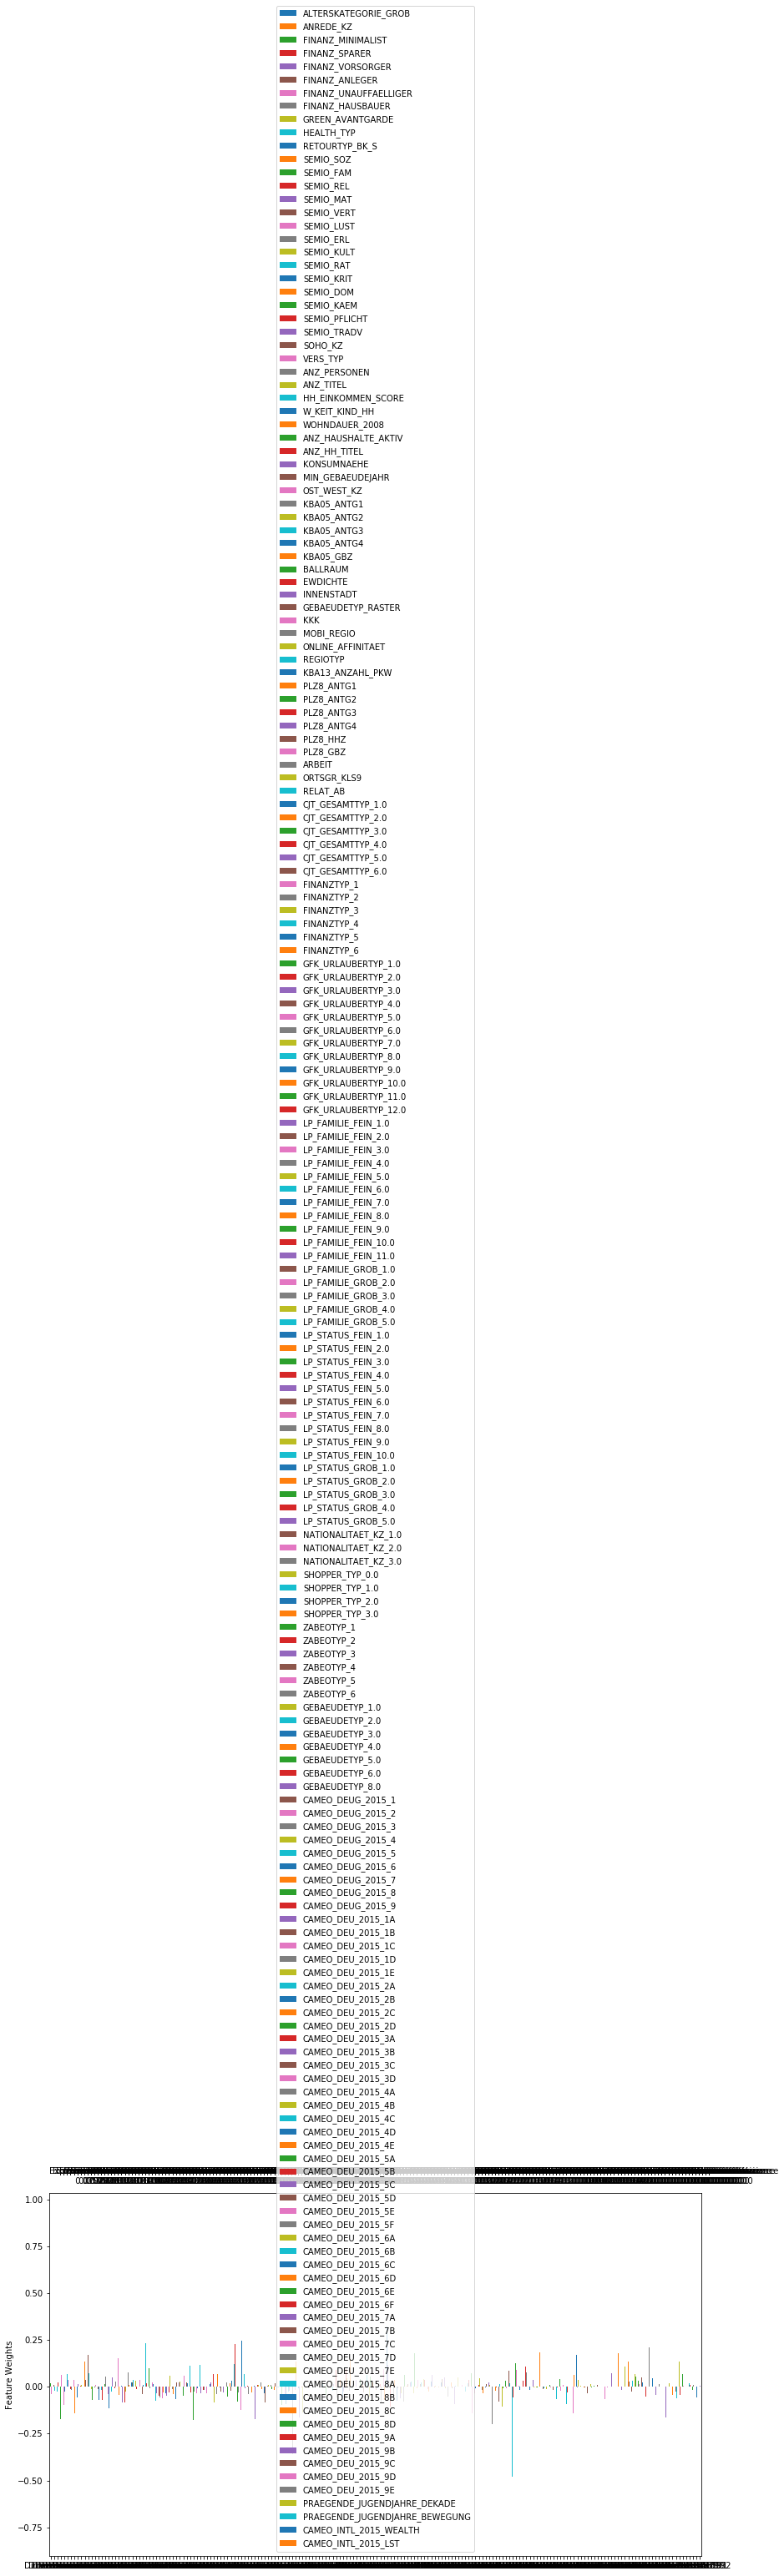

In [65]:
# Investigate the variance accounted for by each principal component.
pca_results(azdias_scaled, pca)


Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1               0.0792               -0.0894     0.0145   
Dimension 2               0.0575                0.2311     0.0407   
Dimension 3               0.0356                0.0154    -0.3443   
Dimension 4               0.0273               -0.0251     0.0897   
Dimension 5               0.0207                0.0482    -0.0248   
Dimension 6               0.0158                0.0135    -0.0001   
Dimension 7               0.0151                0.0155     0.0074   
Dimension 8               0.0133                0.0011    -0.0145   
Dimension 9               0.0131               -0.0488     0.0342   
Dimension 10              0.0126               -0.0216     0.0096   
Dimension 11              0.0121                0.0674    -0.0316   
Dimension 12              0.0120                0.0171     0.0034   
Dimension 13              0.0117                0.0179    -0.0202   
Dimension 14              0.0115                0.0098    -0.0160   
Dimension 15              0.0112                0.0234    -0.0190   

              FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
Dimension 1             -0.1944         0.1210           -0.0895   
Dimension 2              0.0826        -0.2239            0.2165   
Dimension 3              0.1283        -0.0551            0.0464   
Dimension 4             -0.0056         0.0111           -0.0161   
Dimension 5              0.0481        -0.0277            0.0303   
Dimension 6             -0.1174         0.0028            0.0330   
Dimension 7              0.0676        -0.0143           -0.0397   
Dimension 8              0.0616        -0.0370           -0.0396   
Dimension 9             -0.0121         0.0214           -0.0912   
Dimension 10            -0.0459         0.0010            0.0341   
Dimension 11            -0.0802         0.0266           -0.0218   
Dimension 12            -0.0135         0.0069           -0.0229   
Dimension 13            -0.0275         0.0185            0.0048   
Dimension 14             0.0036         0.0109            0.0220   
Dimension 15             0.0195         0.0127           -0.0216   

              FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
Dimension 1           0.0604                 0.0583            0.1480   
Dimension 2          -0.2030                -0.2139            0.0898   
Dimension 3          -0.1539                -0.0458           -0.0614   
Dimension 4          -0.0606                 0.0586           -0.0214   
Dimension 5           0.0248                -0.0970           -0.0404   
Dimension 6           0.0208                 0.0061            0.1858   
Dimension 7          -0.0154                -0.0149           -0.1191   
Dimension 8          -0.0472                -0.0266           -0.0761   
Dimension 9           0.0862                -0.0603            0.0725   
Dimension 10          0.0018                 0.0132            0.0781   
Dimension 11          0.0575                -0.0126            0.0720   
Dimension 12          0.0412                -0.0160            0.0469   
Dimension 13          0.0303                -0.0081           -0.0051   
Dimension 14         -0.0123                 0.0235            0.0045   
Dimension 15          0.0403                -0.0202           -0.0185   

              GREEN_AVANTGARDE         ...           CAMEO_DEU_2015_8D  \
Dimension 1            -0.1067         ...                      0.0247   
Dimension 2            -0.0106         ...                      0.0360   
Dimension 3             0.0771         ...                      0.0004   
Dimension 4             0.2913         ...                     -0.0166   
Dimension 5            -0.1215         ...                      0.0293   
Dimension 6            -0.0377         ...                      0.0169   
Dimension 7            -0.0488         ...                     -0.0668   
Dimension 8            -0.0050         ...                 

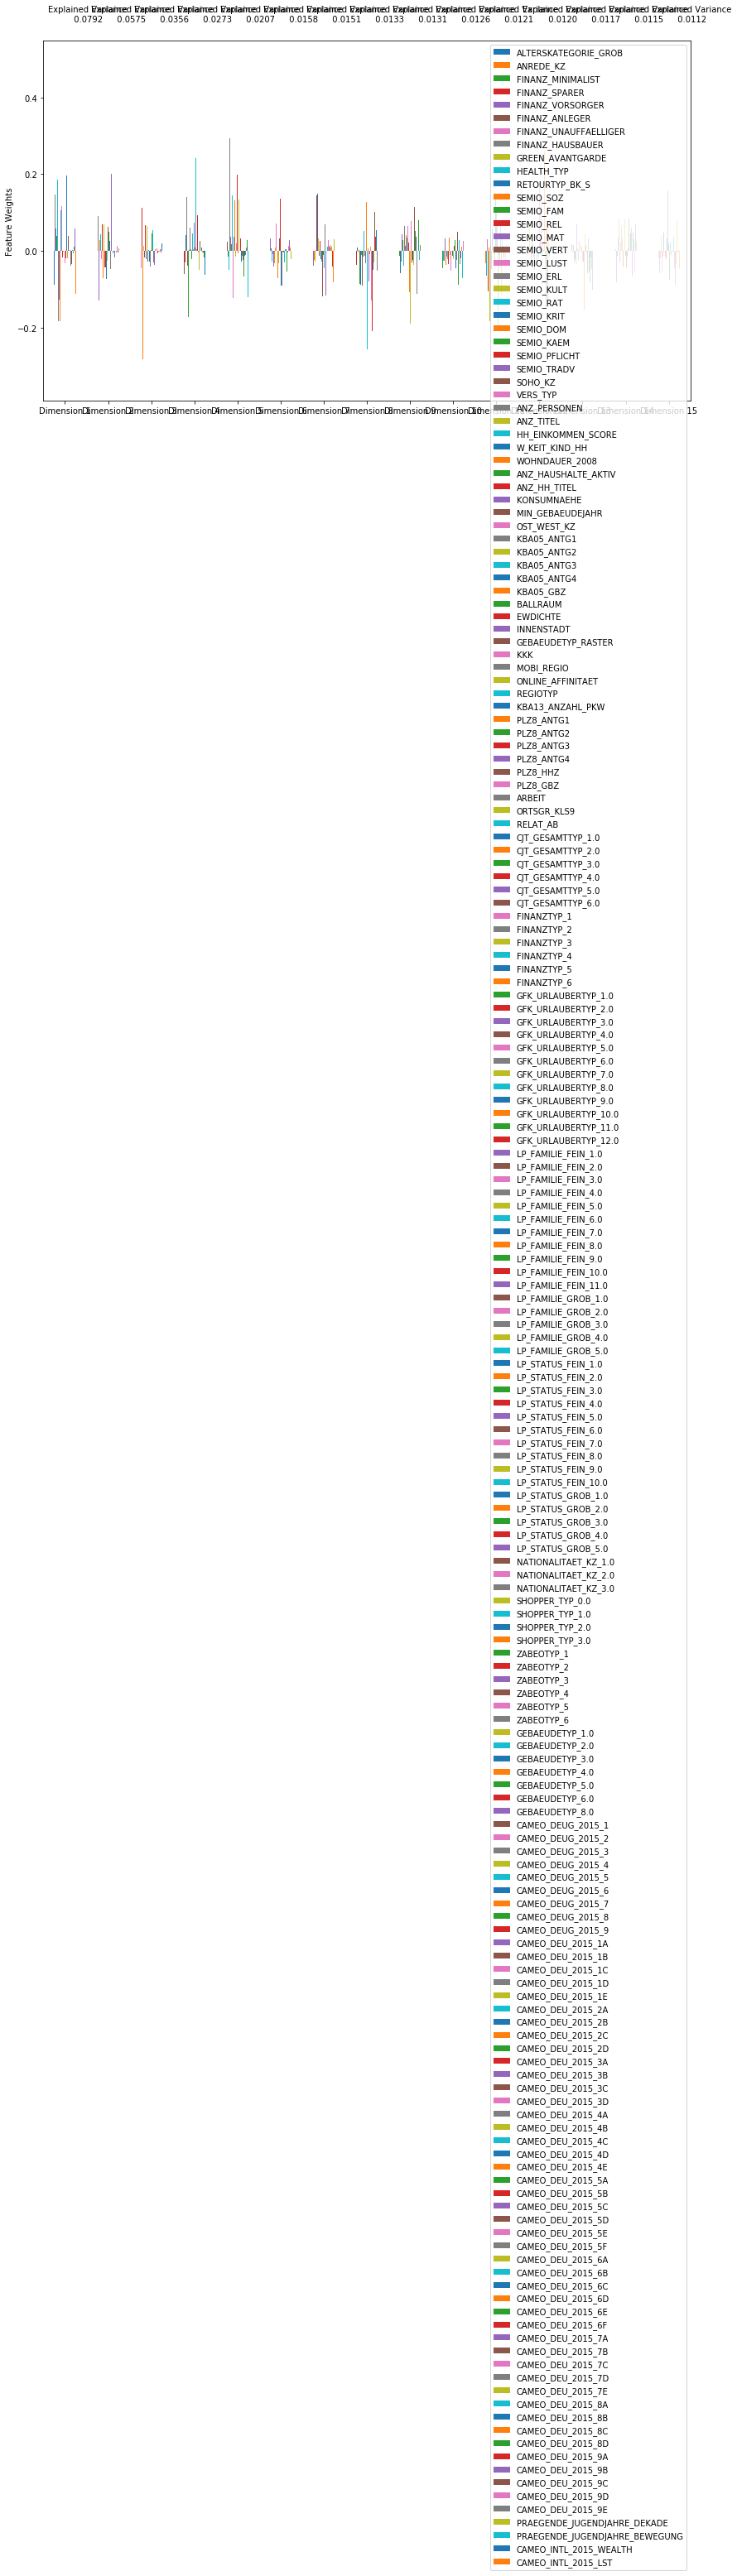

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(n_components = 15)
azdias_pca_2 = pca_2.fit_transform(azdias_scaled)
pca_results(azdias_scaled, pca_2)

In [67]:
pca_2.explained_variance_ratio_.sum()

0.3486575381159151

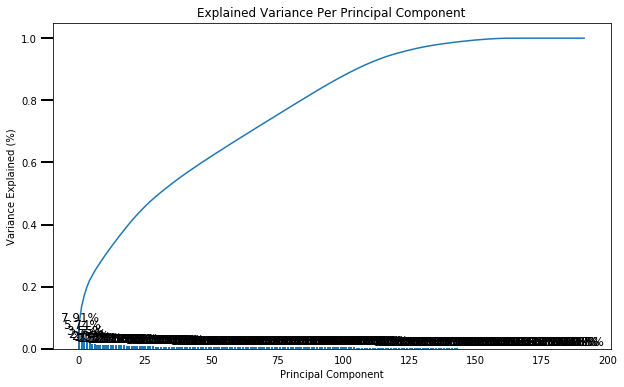

In [68]:
scree_plot(pca)

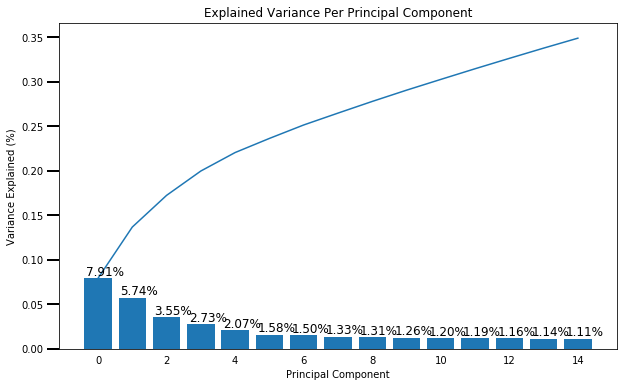

In [69]:
scree_plot(pca_2)

In [ ]:
#pca_3 = PCA(n_components = 140)
#azdias_pca_3 = pca_3.fit_transform(azdias_scaled)

In [ ]:
#scree_plot(pca_3)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

15 principal components are retained for the next step (pca_2).
WIth 15 components a explained variance of 36,76% can be reached, while by increasing the number of PCs, the exp. variance only increases slightly.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
df_pca = pd.DataFrame(pca_2.components_)
df_pca.columns = azdias_scaled.columns

df_pca

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              -0.089403   0.014479          -0.194356       0.120986   
1               0.231117   0.040722           0.082637      -0.223937   
2               0.015373  -0.344301           0.128290      -0.055132   
3              -0.025150   0.089665          -0.005607       0.011101   
4               0.048164  -0.024759           0.048065      -0.027700   
5               0.013546  -0.000052          -0.117428       0.002835   
6               0.015493   0.007379           0.067574      -0.014305   
7               0.001134  -0.014457           0.061589      -0.036984   
8              -0.048775   0.034175          -0.012070       0.021374   
9              -0.021622   0.009599          -0.045853       0.001015   
10              0.067436  -0.031587          -0.080211       0.026612   
11              0.017093   0.003403          -0.013485       0.006941   
12              0.017853  -0.020167          -0.027548       0.018514   
13              0.009760  -0.015987           0.003602       0.010876   
14              0.023449  -0.018973           0.019477       0.012714   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          -0.089536        0.060447               0.058345          0.147974   
1           0.216512       -0.203007              -0.213867          0.089839   
2           0.046413       -0.153861              -0.045837         -0.061352   
3          -0.016054       -0.060614               0.058562         -0.021353   
4           0.030256        0.024833              -0.097006         -0.040449   
5           0.033041        0.020786               0.006065          0.185772   
6          -0.039725       -0.015437              -0.014876         -0.119124   
7          -0.039632       -0.047200              -0.026645         -0.076096   
8          -0.091175        0.086181              -0.060325          0.072518   
9           0.034123        0.001753               0.013244          0.078072   
10         -0.021832        0.057478              -0.012601          0.071984   
11         -0.022851        0.041194              -0.015982          0.046925   
12          0.004787        0.030259              -0.008118         -0.005059   
13          0.021957       -0.012327               0.023528          0.004483   
14         -0.021603        0.040320              -0.020217         -0.018486   

    GREEN_AVANTGARDE  HEALTH_TYP         ...           CAMEO_DEU_2015_8D  \
0          -0.106682    0.033151         ...                    0.024714   
1          -0.010606   -0.054051         ...                    0.036026   
2           0.077106   -0.014745         ...                    0.000445   
3           0.291296   -0.006750         ...                   -0.016589   
4          -0.121488   -0.004323         ...                    0.029324   
5          -0.037662   -0.067438         ...                    0.016867   
6          -0.048818    0.051089         ...                   -0.066766   
7          -0.004995    0.019769         ...                    0.053533   
8           0.033542   -0.042589         ...                    0.081576   
9          -0.048778   -0.025760         ...                    0.002444   
10          0.056431   -0.063979         ...                    0.017733   
11          0.063786   -0.029670         ...                    0.008640   
12          0.013804    0.011812         ...                    0.155136   
13          0.019042    0.024922         ...                   -0.064454   
14          0.026287    0.009246         ...                   -0.030502   

    CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  \
0            0.038971           0.057423           0.058212   
1           -0.004861           0.004586           0.008705   
2           -0.003825           0.013077           0.025931   
3           -0.004698          -0.007296           0.004237   
4     

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight(comp, df):
    sort = df.sort_values(df.index[comp], axis = 1)
    return sort.iloc[[comp]]

In [73]:
# principal component 1
pca_weight(0, df_pca)

FINANZ_MINIMALIST  MOBI_REGIO  KBA05_ANTG1  PLZ8_ANTG1  KBA05_GBZ  \
0          -0.194356    -0.19286    -0.183815    -0.18253  -0.181126   

   KONSUMNAEHE  PLZ8_GBZ  INNENSTADT  LP_STATUS_GROB_5.0  LP_STATUS_FEIN_10.0  \
0    -0.135632 -0.133135   -0.126612           -0.116669            -0.116669   

          ...          LP_STATUS_FEIN_1.0  KBA05_ANTG4  FINANZ_HAUSBAUER  \
0         ...                    0.125393     0.128704          0.147974   

   EWDICHTE  ORTSGR_KLS9  PLZ8_ANTG4  PLZ8_ANTG3  CAMEO_INTL_2015_WEALTH  \
0  0.152176     0.153744    0.174637    0.181645                0.184741   

   HH_EINKOMMEN_SCORE  LP_STATUS_GROB_1.0  
0            0.185934             0.19643  

[1 rows x 192 columns]

In [74]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#principal component 2
pca_weight(1, df_pca)


PRAEGENDE_JUGENDJAHRE_DEKADE  FINANZ_SPARER  SEMIO_REL  \
1                      -0.22899      -0.223937  -0.214322   

   FINANZ_UNAUFFAELLIGER  SEMIO_TRADV  SEMIO_PFLICHT  FINANZ_ANLEGER  \
1              -0.213867    -0.206464      -0.205154       -0.203007   

   SEMIO_RAT  SEMIO_KULT  ONLINE_AFFINITAET          ...           \
1  -0.166579   -0.165655          -0.162895          ...            

   FINANZTYP_5  LP_STATUS_FEIN_1.0  CJT_GESAMTTYP_2.0  W_KEIT_KIND_HH  \
1      0.09788            0.101561            0.10688        0.122586   

   RETOURTYP_BK_S  SEMIO_LUST  SEMIO_ERL  ZABEOTYP_3  FINANZ_VORSORGER  \
1        0.155527    0.160988   0.180007    0.199917          0.216512   

   ALTERSKATEGORIE_GROB  
1              0.231117  

[1 rows x 192 columns]

In [75]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#pincipal component 3
pca_weight(2, df_pca)


ANREDE_KZ  SEMIO_KAEM  SEMIO_DOM  SEMIO_KRIT  SEMIO_ERL  FINANZ_ANLEGER  \
2  -0.344301   -0.314256  -0.282147   -0.265159  -0.206923       -0.153861   

   SEMIO_RAT  FINANZTYP_1  SHOPPER_TYP_2.0  LP_STATUS_FEIN_2.0     ...      \
2  -0.153739    -0.099996        -0.093746           -0.080081     ...       

   SEMIO_MAT  SEMIO_REL  ZABEOTYP_1  SHOPPER_TYP_0.0  FINANZ_MINIMALIST  \
2   0.088604   0.113118    0.116201         0.123238            0.12829   

   FINANZTYP_5  SEMIO_KULT  SEMIO_SOZ  SEMIO_FAM  SEMIO_VERT  
2     0.136816      0.2498   0.257416   0.259801    0.319164  

[1 rows x 192 columns]

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### first principal component

##### positive
- LP_STATUS_GROB_1.0: Social Status, rough scale
- HH_EINKOMMEN_SCORE: Estimated household net income
- CAMEO_INTL_2015_WEALTH: Wealth / Life Stage Typology  

##### negative
- FINANZ_MINIMALIST: Financial typology, low financial interest
- MOBI_REGIO: Movement patterns
- KBA05_ANTG1: Number of 1-2 family houses

Based on the identified feature weihts, the first principal component focuses on high weath, income and status. Opposing features such as low financial interes and small houses have highly negative weights.

#### second principal component

##### positive
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_VORSORGER: financial type: be prepared
- ZABEOTYP_3: Energy consumption typology
- SEMIO_ERL: event-oriented
- SEMIO_LUST: sensual-minded

##### negative
- PRAEGENDE_JUGENDJAHRE_DEKADE: decade in which individual was born
- FINANZ_SPARER: financial type: money-saver
- SEMIO_REL: religious
- SEMIO_PFLICHT:dutiful

Based on the identified feature weihts, the second principal component focuses on age, financial types and some personality types.
As ALTERSKATEGORIE_GROB and PRAEGENDE_JUGENDJAHRE_DEKADE treat the age of the individual contrariwise, it makes sense, that the one variable is positice and the other negative.
Interesting is, that intuitively I wouldn't assume, that the financial types 'be prepared' and 'money-saver' are necessarily opposed.


#### third principal component

##### positive
- SEMIO_VERT: dreamful
- SEMIO_FAM: family-minded
- SEMIO_SOZ: socially-minded
- SEMIO_KULT: cultural-minded

##### negative
- ANREDE_KZ: Gender
- SEMIO_KAEM: combative attitude
- SEMIO_DOM: dominant-minded
- SEMIO_KRIT: critical-minded 	
- SEMIO_ERL: event-oriented

Based on the identified feature weihts, the third principal component focuses on personality typology and gender.
Overall, dreamful, family-minded, socially-minded and cultural-minded can be seen as contrary personality types to combative attitude, dominant-minded, critical-minded and event-oriented.

Sources:
- /Data_Dictionary.md
- https://onlinecourses.science.psu.edu/stat505/lesson/11/11.4

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
# Over a number of different cluster counts...

n_clusters = list(range(1,12))
scores = []
    # run k-means clustering on the data and...
for k in n_clusters:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state = 13)
    model = kmeans.fit(azdias_pca_2)
    
    score= np.abs(model.score(azdias_pca_2))
    
    scores.append(score)
    
    
    # compute the average within-cluster distances.
    
    

In [77]:
kmeans.cluster_centers_

array([[  3.84736464e+00,   4.44047687e+00,  -4.25887513e-01,
          3.81660775e-01,   1.03171835e+00,  -5.29105707e-01,
          9.05160929e-01,  -4.79259732e-01,   1.86279442e-01,
          1.95654507e-01,   9.22154785e-01,  -3.99842933e-02,
         -2.25477225e-02,   8.22237410e-02,  -1.77031847e-01],
       [  3.28299382e-01,   3.49206875e+00,  -2.08504538e+00,
         -1.46947962e-01,  -5.93524291e-01,   1.04231072e+00,
         -5.95720656e-01,   5.05754378e-01,  -3.12344817e-01,
         -3.98520300e-01,  -5.43321001e-02,  -8.28340641e-02,
         -4.44516274e-03,  -2.39081348e-01,   7.44347115e-02],
       [ -1.42935598e+00,  -5.01795609e+00,   2.70340673e+00,
         -4.53349188e-01,  -5.12311592e-01,   7.52311677e-01,
         -2.85353043e-01,   3.62605257e-02,   1.60285674e-01,
         -1.87219015e-01,   4.14310393e-01,   1.59852087e-02,
         -5.27195768e-02,   8.20279824e-03,  -5.72449383e-02],
       [ -3.83820907e+00,  -4.70527747e-01,   1.26585994e+00,
     

Text(0,0.5,'Score')

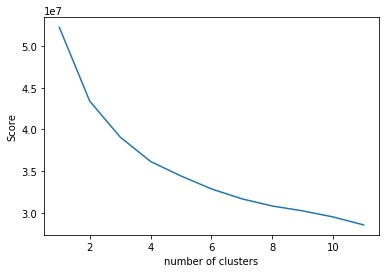

In [78]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(n_clusters, scores)
plt.xlabel('number of clusters')
plt.ylabel('Score')

In [79]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = MiniBatchKMeans(n_clusters=5, random_state = 13)

model = kmeans.fit(azdias_pca_2)

azdias_k = model.predict(azdias_pca_2)

azdias_k



array([3, 3, 1, ..., 3, 0, 4], dtype=int32)

In [ ]:
#azdias_k


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Using ellbow method, 5 clusters were chosen for the segmentation.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [261]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [262]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [263]:
#customers.head()
customers.OST_WEST_KZ

0           W
1         NaN
2           W
3           W
4           W
5           W
6           W
7           W
8           W
9           W
10        NaN
11          W
12          W
13          W
14          W
15          W
16          W
17          W
18          W
19          W
20          W
21          W
22          W
23          W
24          W
25          W
26          W
27          W
28          W
29          W
         ... 
191622      W
191623      W
191624      W
191625      W
191626      W
191627      W
191628      W
191629      W
191630      W
191631      W
191632      W
191633      W
191634      W
191635      W
191636      W
191637      W
191638      W
191639      W
191640      W
191641      W
191642      O
191643      W
191644      W
191645      W
191646      W
191647      W
191648      W
191649      W
191650      W
191651      W
Name: OST_WEST_KZ, Length: 191652, dtype: object

In [264]:
print(len(feat_info))
print(len(missing_or_unknown))

85
85


In [265]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#preprocessing

# TODO: OST WEST Missing Values (NaNs) säubern!
# Dann interpolieren -vgl. clean funktion
customers_clean = clean_data(customers)


In [266]:
customers_clean


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        4.0          1                  5              1   
1                        4.0          1                  5              1   
2                        4.0          2                  5              1   
3                        4.0          1                  5              1   
4                        3.0          1                  3              1   
5                        3.0          1                  5              1   
6                        4.0          1                  5              1   
7                        4.0          1                  5              1   
8                        4.0          2                  2              2   
9                        3.0          1                  5              2   
10                       3.0          2                  4              2   
11                       4.0          1                  5              1   
12                       4.0          1                  5              2   
13                       3.0          1                  5              2   
14                       4.0          2                  3              1   
15                       3.0          1                  5              1   
16                       4.0          1                  5              1   
17                       4.0          1                  4              3   
18                       2.0          1                  2              4   
19                       4.0          2                  3              2   
20                       4.0          1                  5              3   
21                       4.0          1                  3              1   
22                       1.0          2                  5              1   
23                       3.0          1                  3              3   
24                       4.0          2                  4              1   
25                       3.0          2                  5              2   
26                       4.0          2                  5              1   
27                       3.0          1                  5              2   
28                       4.0          2                  3              1   
29                       3.0          2                  3              1   
...                      ...        ...                ...            ...   
191622                   4.0          1                  5              1   
191623                   4.0          1                  5              1   
191624                   4.0          1                  5              1   
191625                   4.0          2                  5              1   
191626                   2.0          1                  3              3   
191627                   3.0          2                  2              1   
191628                   4.0          1                  5              1   
191629                   4.0          2                  2              1   
191630                   3.0          1                  5              1   
191631                   4.0          2                  2              1   
191632                   3.0          1                  4              1   
191633                   4.0          1                  5              1   
191634                   3.0          1                  5              1   
191635                   4.0          2                  5              1   
191636                   4.0          1                  5              1   
191637                   3.0          2                  5              2   
191638                   4.0          1                  3              1   
191639                   3.0          1                  4              3   
191640                   3.0          1                  4              1   
191641                   4.0          1                  5              1   
1916

In [267]:
#
customers_clean_save = copy.copy(customers_clean)

In [ ]:
#feat_num

In [268]:
for attribute in list(azdias_scaled):
    if attribute not in customers_clean:
        print(attribute) 

GEBAEUDETYP_5.0


In [269]:
azdias_scaled.columns.get_loc('GEBAEUDETYP_5.0')

132

In [271]:
#add column GEBAEUDETYP_5.0
customers_clean.insert(loc = 132, column = 'GEBAEUDETYP_5.0', value = 0)

ValueError: cannot insert GEBAEUDETYP_5.0, already exists

In [272]:
feat_num_cust=feat_num.attribute
feat_other_cust = customers_clean.columns

In [273]:
customers_clean[feat_num_cust]=imp_num.transform(customers_clean[feat_num_cust])

In [274]:
customers_clean[feat_other_cust]=imp_cat.transform(customers_clean[feat_other_cust])

In [275]:
customers_clean_save = copy.copy(customers_clean)

In [276]:
customers_clean_save.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0        1.0                5.0            1.0   
1                   4.0        1.0                5.0            1.0   
2                   4.0        2.0                5.0            1.0   
3                   4.0        1.0                5.0            1.0   
4                   3.0        1.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               5.0             1.0                    2.0               2.0   
1               5.0             1.0                    3.0               2.0   
2               5.0             1.0                    4.0               4.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             4.0                    5.0               2.0   

   GREEN_AVANTGARDE  HEALTH_TYP         ...           CAMEO_DEU_2015_8D  \
0               1.0         1.0         ...                         0.0   
1               0.0         1.0         ...                         0.0   
2               1.0         2.0         ...                         0.0   
3               0.0         2.0         ...                         0.0   
4               0.0         3.0         ...                         0.0   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DEKADE  \
0                0.0                          50.0   
1                0.0                          90.0   
2                0.0                          50.0   
3                0.0                          40.0   
4                0.0                          70.0   

   PRAEGENDE_JUGENDJAHRE_BEWEGUNG  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  
0                             1.0                     1.0                  3.0  
1                             0.0                     5.0                  1.0  
2                             1.0                     3.0                  4.0  
3                             0.0                     2.0                  4.0  
4                             0.0                     4.0                  1.0  

[5 rows x 192 columns]

In [277]:
#feature scaling
#scaler = StandardScaler()

customers_clean = pd.DataFrame(scaler.transform(customers_clean))

customers_clean.columns = customers_clean_save.columns
customers_clean.index = customers_clean_save.index

customers_clean.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.180959  -1.043411           1.414618      -1.151087   
1              1.180959  -1.043411           1.414618      -1.151087   
2              1.180959   0.958395           1.414618      -1.151087   
3              1.180959  -1.043411           1.414618      -1.151087   
4              0.198089  -1.043411          -0.036761      -1.151087   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          1.133828       -1.247812              -0.454983         -0.817895   
1          1.133828       -1.247812               0.262544         -0.817895   
2          1.133828       -1.247812               0.980071          0.611953   
3          1.133828       -0.569041              -1.172510         -0.817895   
4          0.407468        0.788502               1.697599         -0.817895   

   GREEN_AVANTGARDE  HEALTH_TYP         ...           CAMEO_DEU_2015_8D  \
0          1.882535   -1.638593         ...                   -0.151267   
1         -0.531199   -1.638593         ...                   -0.151267   
2          1.882535   -0.316158         ...                   -0.151267   
3         -0.531199   -0.316158         ...                   -0.151267   
4         -0.531199    1.006277         ...                   -0.151267   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
0          -0.163813          -0.191144          -0.181397          -0.194377   
1          -0.163813          -0.191144          -0.181397          -0.194377   
2          -0.163813          -0.191144          -0.181397          -0.194377   
3          -0.163813          -0.191144          -0.181397          -0.194377   
4          -0.163813          -0.191144          -0.181397          -0.194377   

   CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DEKADE  \
0           -0.08919                     -1.624758   
1           -0.08919                      1.105284   
2           -0.08919                     -1.624758   
3           -0.08919                     -2.307269   
4           -0.08919                     -0.259737   

   PRAEGENDE_JUGENDJAHRE_BEWEGUNG  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  
0                        1.882535               -1.556031             0.092660  
1                       -0.531199                1.170995            -1.249732  
2                        1.882535               -0.192518             0.763856  
3                       -0.531199               -0.874275             0.763856  
4                       -0.531199                0.489238            -1.249732  

[5 rows x 192 columns]

In [297]:
# pca 
customers_clean_pca = pca_2.transform(customers_clean)

ValueError: operands could not be broadcast together with shapes (191652,193) (192,) 

In [298]:
customers_clean_pca

array([[ -6.83662164e+00,   2.41782895e+00,   3.98212152e+00, ...,
          1.15697316e+00,   8.61354650e-01,  -1.37172439e+00],
       [ -8.34882015e-01,   2.24270382e+00,   2.51704298e+00, ...,
         -1.99232325e-01,   1.04598408e-01,   3.42616269e-02],
       [ -2.12315073e+00,   5.45592750e+00,  -8.68792168e-01, ...,
         -1.60881184e+00,   1.79224562e+00,   2.66534496e-01],
       ..., 
       [ -5.80005328e+00,   3.22768923e+00,   2.46164000e+00, ...,
          1.23912281e+00,   2.77234785e+00,  -4.16821813e-01],
       [ -1.60181300e+00,   2.56876668e+00,  -2.58426394e+00, ...,
         -7.28344210e-01,   2.68559296e+00,  -2.07621820e+00],
       [ -4.94380030e+00,  -2.26388592e+00,   2.40155608e+00, ...,
         -1.99197090e+00,   6.47266690e-03,  -2.20436473e-01]])

In [255]:
model

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=3, random_state=13, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [280]:
#clustering
customers_cluster = model.predict(customers_clean_pca)

In [281]:
customers_cluster

array([2, 4, 2, ..., 2, 1, 1], dtype=int32)

In [282]:
customers_clean['cluster'] = customers_cluster


In [260]:
#ustomers_clean_save['cluster'] = customers_cluster

In [283]:
customers_clean.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.180959  -1.043411           1.414618      -1.151087   
1              1.180959  -1.043411           1.414618      -1.151087   
2              1.180959   0.958395           1.414618      -1.151087   
3              1.180959  -1.043411           1.414618      -1.151087   
4              0.198089  -1.043411          -0.036761      -1.151087   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          1.133828       -1.247812              -0.454983         -0.817895   
1          1.133828       -1.247812               0.262544         -0.817895   
2          1.133828       -1.247812               0.980071          0.611953   
3          1.133828       -0.569041              -1.172510         -0.817895   
4          0.407468        0.788502               1.697599         -0.817895   

   GREEN_AVANTGARDE  HEALTH_TYP   ...     CAMEO_DEU_2015_9A  \
0          1.882535   -1.638593   ...             -0.163813   
1         -0.531199   -1.638593   ...             -0.163813   
2          1.882535   -0.316158   ...             -0.163813   
3         -0.531199   -0.316158   ...             -0.163813   
4         -0.531199    1.006277   ...             -0.163813   

   CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0          -0.191144          -0.181397          -0.194377           -0.08919   
1          -0.191144          -0.181397          -0.194377           -0.08919   
2          -0.191144          -0.181397          -0.194377           -0.08919   
3          -0.191144          -0.181397          -0.194377           -0.08919   
4          -0.191144          -0.181397          -0.194377           -0.08919   

   PRAEGENDE_JUGENDJAHRE_DEKADE  PRAEGENDE_JUGENDJAHRE_BEWEGUNG  \
0                     -1.624758                        1.882535   
1                      1.105284                       -0.531199   
2                     -1.624758                        1.882535   
3                     -2.307269                       -0.531199   
4                     -0.259737                       -0.531199   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  cluster  
0               -1.556031             0.092660        2  
1                1.170995            -1.249732        4  
2               -0.192518             0.763856        2  
3               -0.874275             0.763856        1  
4                0.489238            -1.249732        0  

[5 rows x 193 columns]

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ad28d1128>]], dtype=object)

customers cluster
0     3359
1    40045
2    65127
3    49162
4    33959
dtype: int64

customers cluster
0     1.752656
1    20.894642
2    33.981905
3    25.651702
4    17.719095
dtype: float64

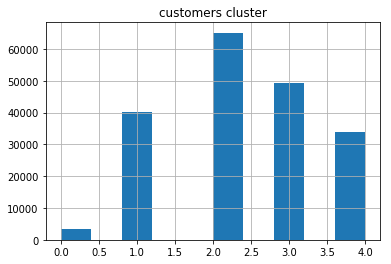

In [284]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_cluster_df = pd.DataFrame(customers_cluster, columns=['customers cluster'])

display(customers_cluster_df.hist())
#customers_cluster_df_count = customers_cluster_df.groupby('customers cluster')
customers_cluster_df_count = customers_cluster_df.groupby('customers cluster').size()
display(customers_cluster_df_count)

customers_cluster_df_percentage = customers_cluster_df_count /customers_cluster_df_count.sum() *100
display(customers_cluster_df_percentage)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ad2a9ea58>]], dtype=object)

general population clusters
0    111035
1    191020
2    128427
3    144139
4    205532
dtype: int64

general population clusters
0    14.232465
1    24.484941
2    16.461771
3    18.475735
4    26.345089
dtype: float64

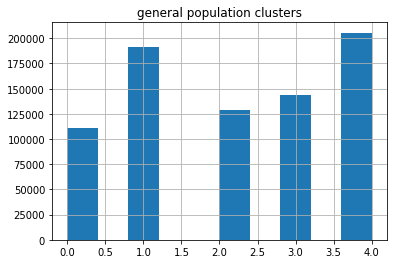

In [285]:
azdias_cluster_df = pd.DataFrame(azdias_k, columns=['general population clusters'])

display(azdias_cluster_df.hist())

azdias_cluster_df_count = azdias_cluster_df.groupby('general population clusters').size()
display(azdias_cluster_df_count)

azdias_cluster_df_percentage = azdias_cluster_df_count /azdias_cluster_df_count.sum() *100
display(azdias_cluster_df_percentage)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


Cluster 2 is the most overrepresented in the customer data set.


In [286]:
customer_cluster_2 = customers_clean.loc[customers_clean['cluster'] == 2]

Cluster 2 is overrepresented in the customer data compared to the general population ( 33.98% to 16.46%).
Also Cluster 3 ist overpresented (25.65% to 18.48%).
On the other Hand, CLuster 0 and 4  are underpresented in the customer data.


In [287]:
customer_cluster_2.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.180959  -1.043411           1.414618      -1.151087   
2              1.180959   0.958395           1.414618      -1.151087   
5              0.198089  -1.043411           1.414618      -1.151087   
6              1.180959  -1.043411           1.414618      -1.151087   
7              1.180959  -1.043411           1.414618      -1.151087   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          1.133828       -1.247812              -0.454983         -0.817895   
2          1.133828       -1.247812               0.980071          0.611953   
5          1.133828       -1.247812              -0.454983         -0.102971   
6          1.133828       -1.247812              -1.172510         -0.817895   
7          1.133828       -1.247812              -0.454983         -0.817895   

   GREEN_AVANTGARDE  HEALTH_TYP   ...     CAMEO_DEU_2015_9A  \
0          1.882535   -1.638593   ...             -0.163813   
2          1.882535   -0.316158   ...             -0.163813   
5          1.882535    1.006277   ...             -0.163813   
6          1.882535   -0.316158   ...             -0.163813   
7          1.882535   -1.638593   ...             -0.163813   

   CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0          -0.191144          -0.181397          -0.194377           -0.08919   
2          -0.191144          -0.181397          -0.194377           -0.08919   
5          -0.191144          -0.181397          -0.194377           -0.08919   
6          -0.191144          -0.181397          -0.194377           -0.08919   
7          -0.191144          -0.181397          -0.194377           -0.08919   

   PRAEGENDE_JUGENDJAHRE_DEKADE  PRAEGENDE_JUGENDJAHRE_BEWEGUNG  \
0                     -1.624758                        1.882535   
2                     -1.624758                        1.882535   
5                     -1.624758                        1.882535   
6                     -1.624758                        1.882535   
7                     -1.624758                        1.882535   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LST  cluster  
0               -1.556031             0.092660        2  
2               -0.192518             0.763856        2  
5               -0.192518             0.763856        2  
6               -0.874275             0.092660        2  
7               -1.556031             1.435052        2  

[5 rows x 193 columns]

In [288]:
#customers_clean_save

In [299]:
#
customers_reverse_1 = pca_2.inverse_transform(customers_clean_pca)
customers_clean_inverse = pd.DataFrame(scaler.inverse_transform(customers_reverse_1))
customers_clean_inverse.columns = customers_clean_save.columns
customers_clean_inverse.index = customers_clean_save.index
customers_clean_inverse

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   3.836855   0.980759           4.927974       0.597602   
1                   3.630308   1.039559           3.919536       1.550468   
2                   4.027083   1.951174           4.270944       0.705441   
3                   3.630629   0.886315           5.125669       1.297783   
4                   2.648672   1.247165           3.249249       2.777496   
5                   3.158398   1.126860           4.800930       1.149523   
6                   3.585546   1.040464           4.952834       0.916550   
7                   3.725879   0.984935           5.199918       0.488997   
8                   4.530184   1.949110           2.182657       1.030422   
9                   3.023250   1.048781           5.024746       2.044610   
10                  3.320028   1.996889           2.853402       2.287776   
11                  3.253272   0.823883           5.033385       1.708195   
12                  3.533738   0.808015           4.985465       1.941498   
13                  3.173871   1.129133           4.759445       2.166403   
14                  4.085319   1.783184           2.897202       1.223445   
15                  3.034437   0.995105           4.963545       1.652249   
16                  3.295408   0.913546           5.218513       1.319395   
17                  2.894025   1.166606           4.460746       2.590539   
18                  1.891188   0.990288           1.830419       4.135624   
19                  3.755721   2.131269           3.416259       1.713988   
20                  3.480999   1.153141           5.014800       1.774318   
21                  3.511844   0.942304           3.432251       1.861961   
22                  3.145490   1.776135           4.158591       1.688374   
23                  3.144927   1.165743           2.979816       2.323702   
24                  4.130032   1.810153           4.762627       0.695222   
25                  3.219644   1.686914           4.296059       2.631091   
26                  4.183466   1.838439           4.324183       0.800243   
27                  2.825240   0.972388           4.486141       2.012268   
28                  4.096691   1.896782           2.978272       1.049047   
29                  3.403252   1.800339           2.741141       1.785550   
...                      ...        ...                ...            ...   
191622              3.782022   1.009434           4.907617       0.675886   
191623              3.552345   1.105795           4.930047       1.364390   
191624              3.294851   0.894646           4.810844       1.443214   
191625              3.919772   1.926763           4.542363       0.447135   
191626              2.439831   0.789599           3.484710       3.019508   
191627              3.880682   1.926897           2.476579       1.433753   
191628              3.975069   0.934232           5.038729       0.899818   
191629              4.486794   1.845416           2.337403       1.016592   
191630              3.508686   0.862097           4.634018       1.293147   
191631              4.137818   1.728473           2.836928       1.050938   
191632              3.346006   1.186893           3.996983       1.928131   
191633              3.769554   1.278648           5.276305       1.187169   
191634              3.634090   1.268854           4.832682       1.320027   
191635              4.250236   1.792176           4.644470       0.380579   
191636              3.531705   0.952435           5.677006       0.398591   
191637              3.123509   1.850852           4.516274       1.823117   
191638              3.765505   1.114546           3.347570       1.577189   
191639              2.586360   1.014731           4.587345       2.776169   
191640              2.718605   1.055360           4.752909       1.773386   
191641              3.614205   0.782939           5.247046       1.260289   
1916

In [316]:
# relevant features identified in pca above
to_compare =['HH_EINKOMMEN_SCORE', 'CAMEO_INTL_2015_WEALTH', 'FINANZ_MINIMALIST', 'MOBI_REGIO', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 
             'ZABEOTYP_3', 'SEMIO_ERL', 'SEMIO_LUST', 'PRAEGENDE_JUGENDJAHRE_DEKADE', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_PFLICHT', 
             'SEMIO_VERT', 'SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_KULT', 'ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_ERL']

In [300]:
customers_clean_inverse['cluster'] = customers_cluster
customers_clean_inverse_2 = customers_clean_inverse.loc[customers_clean_inverse['cluster'] == 2]


In [313]:
cl_2_mean = pd.Series(customer_cluster_2.mean() ,name='cl_2_mean')
display(cl_2_mean)

ALTERSKATEGORIE_GROB              0.734142
ANREDE_KZ                        -0.535114
FINANZ_MINIMALIST                 1.253205
FINANZ_SPARER                    -0.942748
FINANZ_VORSORGER                  0.875425
FINANZ_ANLEGER                   -0.989798
FINANZ_UNAUFFAELLIGER            -0.526420
FINANZ_HAUSBAUER                 -0.681633
GREEN_AVANTGARDE                  1.777279
HEALTH_TYP                       -0.449037
RETOURTYP_BK_S                    0.346721
SEMIO_SOZ                         0.183321
SEMIO_FAM                        -0.095212
SEMIO_REL                        -0.400470
SEMIO_MAT                        -0.149740
SEMIO_VERT                        0.662740
SEMIO_LUST                        0.645188
SEMIO_ERL                        -0.012332
SEMIO_KULT                       -0.019390
SEMIO_RAT                        -0.692648
SEMIO_KRIT                       -0.549950
SEMIO_DOM                        -0.354614
SEMIO_KAEM                       -0.558704
SEMIO_PFLIC

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#On the other Hand, CLuster 0 is underrepresented in the customer data (1.75% to 14.23%).

In [303]:
customers_clean_inverse_4 = customers_clean_inverse.loc[customers_clean_inverse['cluster'] == 4]

In [292]:
#customer_cluster_4 = customers_clean_save.loc[customers_clean['cluster'] == 4]

In [306]:
cl_4_mean = pd.Series(customers_clean_inverse_4.mean(), name='cl_4_mean')

display(cl_4_mean)

ALTERSKATEGORIE_GROB               3.690735
ANREDE_KZ                          1.464381
FINANZ_MINIMALIST                  3.236713
FINANZ_SPARER                      1.438738
FINANZ_VORSORGER                   4.665579
FINANZ_ANLEGER                     1.409292
FINANZ_UNAUFFAELLIGER              1.489004
FINANZ_HAUSBAUER                   4.030593
GREEN_AVANTGARDE                   0.196198
HEALTH_TYP                         2.041401
RETOURTYP_BK_S                     4.488139
SEMIO_SOZ                          4.167528
SEMIO_FAM                          3.621377
SEMIO_REL                          2.640318
SEMIO_MAT                          3.207660
SEMIO_VERT                         4.573258
SEMIO_LUST                         5.803975
SEMIO_ERL                          5.531572
SEMIO_KULT                         3.266785
SEMIO_RAT                          2.651630
SEMIO_KRIT                         4.618733
SEMIO_DOM                          4.370545
SEMIO_KAEM                      

In [310]:
# identify variables with biggest differences between over- and underrepresented
cl_diff = pd.Series(abs(cl_2_mean - cl_4_mean),  name='cl_diff')
series = [cl_2_mean, cl_4_mean, cl_diff]
diff_df = pd.concat(series, axis=1)
#diff_df = pd.DataFrame(diff_df, columns=['cl_4_mean', 'cl_3_mean', 'cl_diff'])
diff_df
#display(diff_df.nlargest(n=10, columns='cl_diff'))
        

cl_2_mean  cl_4_mean   cl_diff
ALTERSKATEGORIE_GROB             3.438524   3.690735  0.252211
ANREDE_KZ                        1.265622   1.464381  0.198759
FINANZ_MINIMALIST                4.727626   3.236713  1.490913
FINANZ_SPARER                    1.400153   1.438738  0.038585
FINANZ_VORSORGER                 4.487657   4.665579  0.177921
FINANZ_ANLEGER                   1.345143   1.409292  0.064150
FINANZ_UNAUFFAELLIGER            2.068206   1.489004  0.579201
FINANZ_HAUSBAUER                 2.196929   4.030593  1.833664
GREEN_AVANTGARDE                 0.937415   0.196198  0.741218
HEALTH_TYP                       1.994823   2.041401  0.046577
RETOURTYP_BK_S                   3.955298   4.488139  0.532841
SEMIO_SOZ                        4.776039   4.167528  0.608511
SEMIO_FAM                        4.042038   3.621377  0.420661
SEMIO_REL                        3.139909   2.640318  0.499591
SEMIO_MAT                        3.220287   3.207660  0.012627
SEMIO_VERT                       5.576761   4.573258  1.003503
SEMIO_LUST                       5.537374   5.803975  0.266601
SEMIO_ERL                        4.695209   5.531572  0.836363
SEMIO_KULT                       4.018013   3.266785  0.751228
SEMIO_RAT                        2.672121   2.651630  0.020491
SEMIO_KRIT                       3.624763   4.618733  0.993969
SEMIO_DOM                        3.911813   4.370545  0.458733
SEMIO_KAEM                       3.384366   4.276763  0.892397
SEMIO_PFLICHT                    2.924078   2.684791  0.239287
SEMIO_TRADV                      2.847088   2.332607  0.514480
SOHO_KZ                          0.009985   0.007953  0.002032
VERS_TYP                         1.528169   1.598353  0.070184
ANZ_PERSONEN                     2.562433   1.619776  0.942657
ANZ_TITEL                        0.015591   0.011198  0.004392
HH_EINKOMMEN_SCORE               2.219297   5.031493  2.812196
...                                   ...        ...       ...
CAMEO_DEU_2015_5B                0.004676   0.009849  0.005173
CAMEO_DEU_2015_5C               -0.000455   0.009676  0.010131
CAMEO_DEU_2015_5D                0.030871   0.049665  0.018794
CAMEO_DEU_2015_5E                0.005558   0.007748  0.002190
CAMEO_DEU_2015_5F                0.007915   0.008328  0.000413
CAMEO_DEU_2015_6A                0.003774   0.010713  0.006939
CAMEO_DEU_2015_6B                0.044681   0.085575  0.040894
CAMEO_DEU_2015_6C                0.018027   0.029312  0.011286
CAMEO_DEU_2015_6D                0.008283   0.011939  0.003656
CAMEO_DEU_2015_6E                0.015621   0.046916  0.031296
CAMEO_DEU_2015_6F                0.006489   0.012497  0.006009
CAMEO_DEU_2015_7A               -0.011024   0.057048  0.068072
CAMEO_DEU_2015_7B               -0.007421   0.054295  0.061716
CAMEO_DEU_2015_7C                0.000983   0.024965  0.023982
CAMEO_DEU_2015_7D                0.000840   0.015046  0.014205
CAMEO_DEU_2015_7E                0.003398   0.011938  0.008540
CAMEO_DEU_2015_8A                0.006333   0.091806  0.085472
CAMEO_DEU_2015_8B                0.024110   0.069564  0.045454
CAMEO_DEU_2015_8C                0.007595   0.053468  0.045873
CAMEO_DEU_2015_8D                0.008811   0.046356  0.037545
CAMEO_DEU_2015_9A               -0.002489   0.023695  0.026183
CAMEO_DEU_2015_9B               -0.007839   0.032959  0.040798
CAMEO_DEU_2015_9C                0.000924   0.038934  0.038011
CAMEO_DEU_2015_9D               -0.001884   0.045754  0.047638
CAMEO_DEU_2015_9E                0.005518   0.024607  0.019089
PRAEGENDE_JUGENDJAHRE_DEKADE    63.147845  60.423113  2.724732
PRAEGENDE_JUGENDJAHRE_BEWEGUNG   0.937415   0.196198  0.741218
CAMEO_INTL_2015_WEALTH           1.794559   4.055342  2.260783
CAMEO_INTL_2015_LST              3.827256   2.800747  1.026509
cluster                          2.000000   4.000000  2.000000

[193 rows x 3 columns]

In [328]:
# compare relevant features of clusters 

compare_df = diff_df.loc[to_compare]
compare_df.sort_values(by=['cl_diff'], ascending=False)

cl_2_mean  cl_4_mean   cl_diff
HH_EINKOMMEN_SCORE             2.219297   5.031493  2.812196
PRAEGENDE_JUGENDJAHRE_DEKADE  63.147845  60.423113  2.724732
CAMEO_INTL_2015_WEALTH         1.794559   4.055342  2.260783
MOBI_REGIO                     4.167596   2.078984  2.088612
FINANZ_MINIMALIST              4.727626   3.236713  1.490913
SEMIO_VERT                     5.576761   4.573258  1.003503
SEMIO_KRIT                     3.624763   4.618733  0.993969
SEMIO_KAEM                     3.384366   4.276763  0.892397
SEMIO_ERL                      4.695209   5.531572  0.836363
SEMIO_ERL                      4.695209   5.531572  0.836363
SEMIO_KULT                     4.018013   3.266785  0.751228
SEMIO_SOZ                      4.776039   4.167528  0.608511
SEMIO_REL                      3.139909   2.640318  0.499591
SEMIO_DOM                      3.911813   4.370545  0.458733
SEMIO_FAM                      4.042038   3.621377  0.420661
ZABEOTYP_3                     0.398192   0.721451  0.323260
SEMIO_LUST                     5.537374   5.803975  0.266601
ALTERSKATEGORIE_GROB           3.438524   3.690735  0.252211
SEMIO_PFLICHT                  2.924078   2.684791  0.239287
ANREDE_KZ                      1.265622   1.464381  0.198759
FINANZ_VORSORGER               4.487657   4.665579  0.177921
FINANZ_SPARER                  1.400153   1.438738  0.038585

In [53]:
diff_df.nlargest(n=12, columns='cl_diff')

NameError: name 'diff_df' is not defined

### Discussion 3.3: Compare Customer Data to Demographics Data

- Findings and conclusions from the clustering analysis.
- Can we describe segments of the population that are relatively popular with the mail-order company 
- Or relatively unpopular with the company?

CLuster 2 is overrepresented in the customer dataset. This cluster can be specified as:

   - Households with very high income (Mean HH_EINKOMMEN_SCORE at ~2)
     
   - Wealthy and Prosperous Households (Mean CAMEO_INTL_2015_WEALTH at 1-2)
     
   - Individuals live in regions with low movement patterns (Mean MOBI_REGIO ~4)
   - highly critical-minded Personality (Mean SEMIO_KRIT ~ 3-4)
     
   - Person with high typology of home ownership (Mean FINANZ_HAUSBAUER at ~2)      
   - Individuals with high affinity for combative attitude (Mean SEMIO_KAEM at ~3)
    
 

CLuster 4 is underrepresented in the customer dataset. This cluster can be specified as:
        
   - Households with lower income (Mean HH_EINKOMMEN_SCORE at ~5) 

   - Less Affluent Households (Mean CAMEO_INTL_2015_WEALTH at ~4)
        
   - Individuals live in regions with high movement patterns (Mean MOBI_REGIO ~2)
        
   - average to low critical-minded Personality (Mean SEMIO_KRIT ~ 4-5)
        
   - Person with low typology of home ownership (Mean FINANZ_HAUSBAUER at ~2)
   
   - Individuals with average affinity for combative attitude (Mean SEMIO_KAEM at ~3)
    

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.